In [1]:
import numpy as np
import scipy.signal
from scipy.optimize import minimize
import pandas as pd
pd.set_option('max_columns', None)
from sklearn import linear_model
import matplotlib.pyplot as plt
from datetime import datetime
plt.rcParams['figure.figsize'] = [15, 7.5]
plt.rcParams.update({'font.size': 16,'legend.fontsize':16})
import seaborn as sns
import sys
import os
import fur.path_assistant as path_assistant
from fur.waveform_reader import read_waveform
from fur.finding_period import get_period
from fur.fluctuations import get_fluctiation_and_noise_var
from fur.one_data_set_analyzer import analyze_one_dataset
from fur.extending_with_acnet_data import get_fluctuations_df_with_acnet_data, get_acnet_df_with_bunch_sizes
shift = path_assistant.PathAssistant('shift_03_16_2020',
    ignore_files=['RefCurve_2020-03-16_0_084020_test.Wfm.bin',
                  'RefCurve_2020-03-16_153_155200.Wfm.bin'])
#shift_03_09_2020.show_waveform_file_names()
waveforms_dir = shift.get_waveforms_dir()
results_dir = shift.get_results_dir()
from config import get_from_config, save_to_config
from wiggler_radiation.number_of_coherent_modes.coherent_modes import get_M_interpolator_at_fixed_energy
import lattice.lattice as lattice
from lattice.summary_in_undulator import CalcTransverseBeamParams
from wiggler_radiation.Wigrad.wigrad_generator import \
    generate_wr_sim_with_wigrad_results_and_spectral_transmission
import coherent_modes_cpp as cm
import matplotlib.ticker as ticker

In [2]:
cur_to_sum_channel = get_from_config("Beam_current_to_Sum_channel_ampl_V/mA")
sum_channel_to_photoelectrons =\
    get_from_config('sum_channel_to_photoelectrons')
meas_photons_per_electron =\
    get_from_config("Measured_photons_per_electron")
meas_photons_per_electron

0.008798823311458544

In [3]:
from scipy.interpolate import interp1d
bp_df = pd.read_csv(
    shift.get_results_dir().fi("beam_params_vs_current_round.csv"))
sx_func = interp1d(bp_df["N"], bp_df['Sigma_um_X'],
                   bounds_error=False, fill_value="extrapolate")
sy_func = interp1d(bp_df["N"], bp_df['Sigma_um_Y'],
                   bounds_error=False, fill_value="extrapolate")
sz_func = interp1d(bp_df["N"], bp_df['sz_um'],
                   bounds_error=False, fill_value="extrapolate")
ex_func = interp1d(bp_df["N"], bp_df['ex_um'],
                   bounds_error=False, fill_value="extrapolate")
ey_func = interp1d(bp_df["N"], bp_df['ey_um'],
                   bounds_error=False, fill_value="extrapolate")
dpp_func = interp1d(bp_df["N"], bp_df['dp/p'],
                    bounds_error=False, fill_value="extrapolate")

In [4]:
Ibeam = get_from_config("NominalBeamCurrent_mA")
N_to_I = 1/sum_channel_to_photoelectrons/cur_to_sum_channel

In [5]:
m0 = 10000
mfold = 8
seed = 1

In [6]:
lattice_df = \
    lattice.read_lattice_file(shift.get_6dsim_dir()\
    .fi("IOTA_1NL_100MeV_v8.6.1.4.6ds_data.txt"))

In [7]:
N0s = np.linspace(0.7e7, 2.25e7, 3)
df_to_save = pd.DataFrame({"N": np.concatenate([[0], N0s])})

In [8]:
Ebeam0 = get_from_config("gamma")*0.511
Ebeam_error = get_from_config("Ebeam_error_MeV")
Ku0 = get_from_config("K_peak")
Ku_error = get_from_config("Ku_error")

In [9]:
EK_list = [
    [Ebeam0, Ku0, 'Middle']]

In [10]:
# for j,EKpos in enumerate(EK_list):
#     E_in, K_peak_in, where_in_und = EKpos
#     gamma_in = E_in/0.511
#     print(f"Working on EK {j+1} out of {len(EK_list)}")
#     wr_sim, spect = generate_wr_sim_with_wigrad_results_and_spectral_transmission(
#     K_peak_in=K_peak_in,
#     gamma_in=gamma_in)
#     ampx3d = wr_sim.get_amplittude_3D(polarization='x')
#     mesh = get_from_config("radiation_mesh")
#     zobs = get_from_config("z_obs_m")
#     xmin, xmax, _ = mesh[0]
#     xmin = xmin/zobs
#     xmax = xmax/zobs
#     ymin, ymax, _ = mesh[1]
#     ymin = ymin/zobs
#     ymax = ymax/zobs
#     lmin, lmax, _ = mesh[2]
#     dax = (xmax-xmin)/(mesh[0][2]-1)
#     day = (ymax-ymin)/(mesh[1][2]-1)
#     dl = (lmax-lmin)/(mesh[2][2]-1)
#     elliptic_aperture = \
#         (wr_sim.x_3D**2/xmax**2+wr_sim.y_3D**2/ymax**2) < 1
#     sm =dax*day*dl*np.sum(
#         spect[:,None,None]*np.absolute(ampx3d*elliptic_aperture)**2)
#     Ms = np.zeros(N0s.shape)
#     for i,N0 in enumerate(N0s):
#         print(f"Working on {i+1} out of {len(N0s)}")
#         ex = ex_func(N0)
#         ey = ey_func(N0)
#         dpp = dpp_func(N0)
#         st = sz_func(N0)
#         # here ypu can adjust emittances to see how the result changes
#         adj = 1.0
#         Sx, Sy, dx, dy, sxp, syp = CalcTransverseBeamParams(
#             lattice_df,adj*ex,adj*ey,dpp,where_in_und)
#         sx = np.sqrt(Sx**2+sxp**2*dx**2)
#         sy = np.sqrt(Sy**2+syp**2*dy**2)
#         Sx, Sy, dx, dy, sxp, syp = sx, sy, 0, 0, 0, 0
#         coh_modes_cpp_args =  np.asarray([Sx,Sy,dx,dy,sxp,syp,xmin,xmax,ymin,ymax,lmin,lmax,
#                                           st, sm, m0,mfold,seed],
#                                         dtype=np.float64)
#         Ms[i] = np.real(
#             cm.CalcMFromPrecalculatedFieldAmps(ampx3d,spect,coh_modes_cpp_args)[-1])
#     df_to_save[f"{E_in},{K_peak_in},{where_in_und}"] = np.concatenate([[0], N0s+N0s**2/Ms])
# df_to_save.to_csv("theor_NvarN_no_div.csv")

In [11]:
df_to_save = pd.read_csv("theor_NvarN_no_div.csv", index_col=0)

In [12]:
varNnodivfunc = interp1d(df_to_save['N'],
                         df_to_save['96.400000000038,1.0,Middle'],
                   bounds_error=False, fill_value="extrapolate", kind="cubic")

In [13]:
nvarn_df = pd.read_csv("theor_NvarN.csv", index_col=0)
Ns = nvarn_df['N']
varN0 = nvarn_df.iloc[:,1]
EerrT = nvarn_df.iloc[:,2]-varN0
EerrB = varN0-nvarn_df.iloc[:,3]
KerrT = 0
KerrB = 0
PerrB = 0
PerrT = 0 # both ends of the undulator are Bottom
errT = np.sqrt(EerrT**2+KerrT**2+PerrT**2)
errB = np.sqrt(EerrB**2+KerrB**2+PerrB**2)
varNT = varN0+errT
varNB = varN0-errB
varN0func = interp1d(Ns, varN0,
                   bounds_error=False, fill_value="extrapolate", kind="cubic")
varNTfunc = interp1d(Ns, varNT,
                   bounds_error=False, fill_value="extrapolate", kind="cubic")
varNBfunc = interp1d(Ns, varNB,
                   bounds_error=False, fill_value="extrapolate", kind="cubic")
pd.DataFrame({"EerrB":EerrB, "KerrB":KerrB, "PerrB":PerrB})

,EerrB,KerrB,PerrB
0,0.000000e+00,0,0
1,1.962058e+06,0,0
2,6.319925e+06,0,0
3,1.192460e+07,0,0


In [14]:
# nvarn_df = pd.read_csv("theor_NvarN_exey_err.csv", index_col=0)
# Ns = nvarn_df['N']
# varN0 = nvarn_df.iloc[:,1]
# EerrT = nvarn_df.iloc[:,2]-varN0
# EerrB = varN0-nvarn_df.iloc[:,3]
# exerrT = nvarn_df.iloc[:,4]-varN0
# exerrB = varN0-nvarn_df.iloc[:,5]
# eyerrT = nvarn_df.iloc[:,6]-varN0
# eyerrB = varN0-nvarn_df.iloc[:,7]
# errT = np.sqrt(EerrT**2+exerrT**2+eyerrT**2)
# errB = np.sqrt(EerrB**2+exerrB**2+eyerrB**2)
# varNT = varN0+errT
# varNB = varN0-errB
# varN0func = interp1d(Ns, varN0,
#                    bounds_error=False, fill_value="extrapolate", kind="cubic")
# varNTfunc = interp1d(Ns, varNT,
#                    bounds_error=False, fill_value="extrapolate", kind="cubic")
# varNBfunc = interp1d(Ns, varNB,
#                    bounds_error=False, fill_value="extrapolate", kind="cubic")
# pd.DataFrame({"EerrT":EerrT, "ErrB":EerrB,
#               "exerrT":exerrT, "exerrB":exerrB,
#               "eyerrT":eyerrT, "eyerrB":eyerrB})

In [15]:
x = np.linspace(0,2.25e7,50)
theor_df = pd.DataFrame({"N": x})
theor_df["varN"] = varN0func(x)
theor_df['varN_bottom'] = varNBfunc(x)
theor_df['varN_top'] = varNTfunc(x)
theor_df['varN_nodiv'] = varNnodivfunc(x)
def calcM(n, varN):
    return n**2/(varN-n)
theor_df['M'] = calcM(theor_df['N'], theor_df['varN'])
theor_df['M_top'] = calcM(theor_df['N'], theor_df['varN_bottom'])
theor_df['M_bottom'] = calcM(theor_df['N'], theor_df['varN_top'])
theor_df['M_nodiv'] = calcM(theor_df['N'], theor_df['varN_nodiv'])

In [16]:
hybrid_balance_error = get_from_config("HybridBalanceError")
fit_errorbar = get_from_config("varN_error_fit")

In [17]:
# AAAAAAAAAAAAAAAAAAAAAAAAAAAAAA
meas_ROUND = \
    pd.read_csv(shift.get_results_dir().fi('meas_ROUND_03_16_2020.csv'),
                index_col=0)
meas_ROUND['M'] = meas_ROUND['N']**2/(meas_ROUND['varN']-meas_ROUND['N'])
hybrid_errorbar = 2*hybrid_balance_error\
    *np.absolute(meas_ROUND['varN'])
error_barA = np.sqrt(0*hybrid_errorbar**2+fit_errorbar**2)

# BBBBBBBBBBBBBBBBBBBBBBBBBBBBB
meas_FLAT =\
    pd.read_csv(path_assistant.PathAssistant('shift_03_10_2020')\
                .get_results_dir().fi('meas_FLAT_ND_FILTERS_03_10_2020.csv'), index_col=0)
meas_FLAT = meas_FLAT[meas_FLAT['N'] > 0.75e7]
meas_FLAT = meas_FLAT.sort_values(by='N').reset_index(drop=True)
meas_FLAT['pt_idx'] = [0,0,0,1,1,1,2,2,2,3,3,3,4]
new_df = meas_FLAT.groupby('pt_idx').mean()
new_df['varN_stat_err'] = meas_FLAT.groupby('pt_idx').std()['varN'].fillna(value=0)
meas_FLAT = new_df
meas_FLAT['M'] = meas_FLAT['N']**2/(meas_FLAT['varN']-meas_FLAT['N'])
hybrid_errorbar = 2*hybrid_balance_error\
    *np.absolute(meas_FLAT['varN'])
error_barB = np.sqrt(0*hybrid_errorbar**2+fit_errorbar**2)

In [18]:
meas_FLAT

,N,varN,errorbar,varN_stat_err,M
pt_idx,,,,,
0,9.378317e+06,3.016326e+07,2.688549e+06,1.440756e+06,4.231564e+06
1,1.122141e+07,3.954706e+07,2.688549e+06,1.972020e+06,4.445438e+06
2,1.356505e+07,5.610427e+07,2.688549e+06,3.835218e+05,4.325672e+06
3,1.712878e+07,8.256660e+07,2.688549e+06,1.677756e+06,4.483569e+06
4,2.048563e+07,1.151118e+08,2.688549e+06,0.000000e+00,4.434935e+06


In [19]:

for df in [meas_ROUND, meas_FLAT]:
    df['MerrT'] = calcM(df['N'], df['varN']-df['errorbar'])-df['M']
    df['MerrB'] = df['M'] - calcM(df['N'], df['varN']+df['errorbar'])

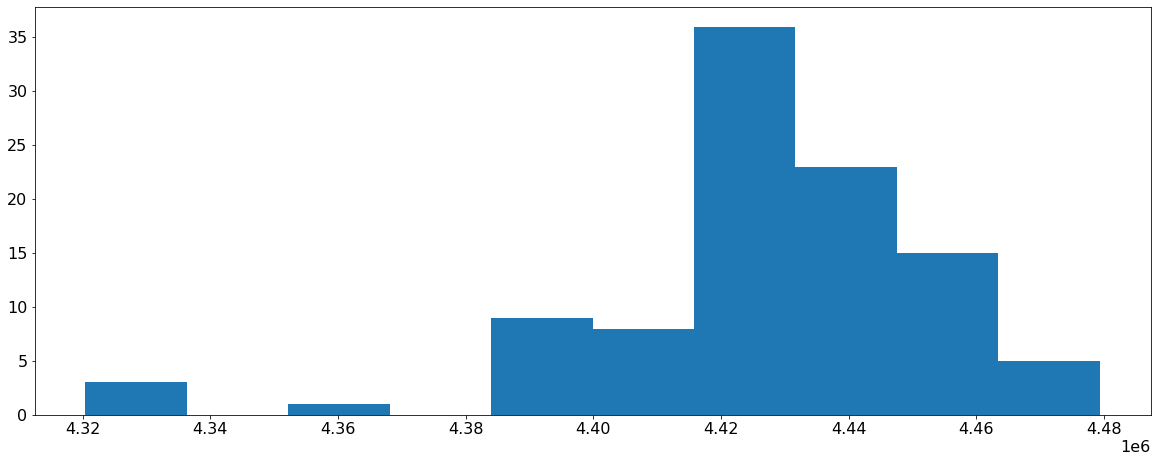

(4427590.264365159, 27103.535105756506)

In [20]:
from scipy.optimize import curve_fit
def f(n, Mpar):
    return n+n**2/Mpar
def getMfit(in_df):
    popt, pcov = curve_fit(f, in_df['N'], in_df['varN'], p0=4e6)
    Mval = popt[0]
    Merr = np.sqrt(np.diag(pcov))
    return Mval
npts = len(meas_FLAT.index)
def getOneM():
    idxs = np.random.randint(0,npts, size=npts)
    in_df = meas_FLAT.iloc[idxs,:]
    return getMfit(in_df)
Mvals = [getOneM() for _ in range(100)]
plt.hist(Mvals)
plt.show()
M_ND_best = np.mean(Mvals)
M_ND_err = np.std(Mvals)
M_ND_best, M_ND_err

In [21]:
in_df = meas_FLAT
popt, pcov = curve_fit(f, in_df['N'], in_df['varN'], p0=4e6)
Mval = popt[0]
Merr = np.sqrt(np.diag(pcov))[0]
Mval, Merr

(4431387.88118894, 27546.001456514638)

In [22]:
M_ND_best, M_ND_err = in_df['M'].mean(),in_df['M'].std()
M_ND_best, M_ND_err

(4384235.5882732915, 103587.93879094017)

In [23]:
sh10 = path_assistant.PathAssistant('shift_03_10_2020')
from fur.jsonstorage import JsonStorage
js10 = JsonStorage(sh10.get_results_dir().fi('jsonstorage_03_10_2020.json'))

In [24]:
js10.save("observed_M", M_ND_best)
js10.save("M_err", M_ND_err)

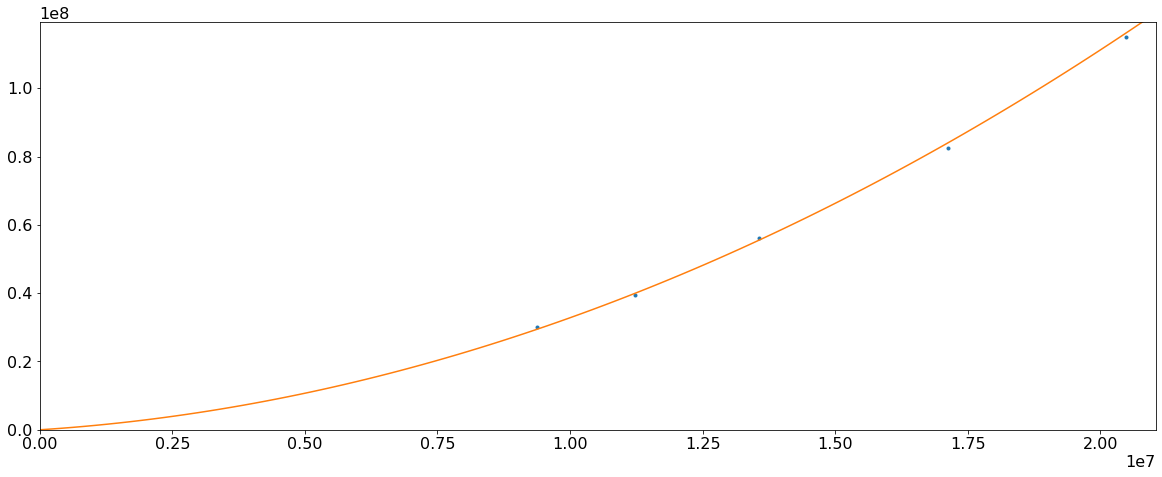

In [25]:
fig, ax = plt.subplots()
ax.plot(meas_FLAT['N'], meas_FLAT['varN'], '.')
ax.set_ylim(0, ax.get_ylim()[1])
ax.set_xlim(0, ax.get_xlim()[1])
xs = np.linspace(0,ax.get_xlim()[1], 100)
ax.plot(xs, f(xs, M_ND_best))
plt.show()

In [26]:
sh10 = path_assistant.PathAssistant('shift_03_10_2020')
from fur.jsonstorage import JsonStorage
js10 = JsonStorage(sh10.get_results_dir().fi('jsonstorage_03_10_2020.json'))
Ibeam = js10.get("Ibeam")

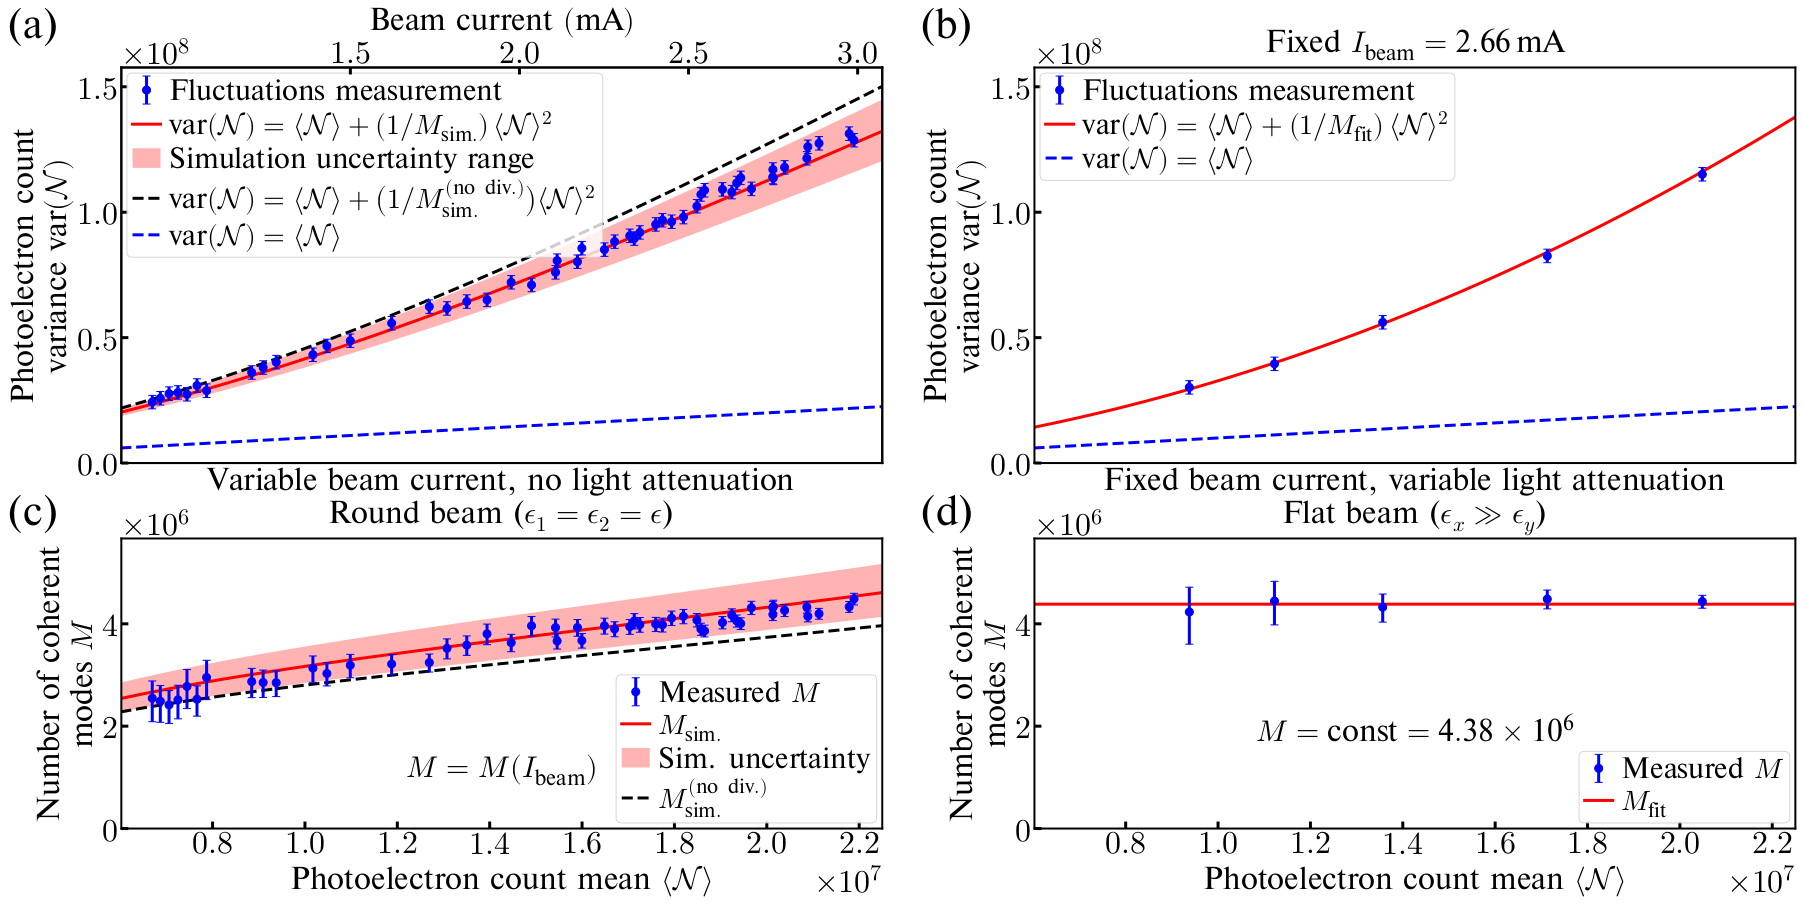

In [66]:
from fur.path_assistant import get_plot_style_sheet
import matplotlib as mpl
mpl.use("pgf")
plt.style.use(get_plot_style_sheet("prab"))
plt.rc('pgf', preamble=\
       r'\usepackage{amsmath}'
       +r'\usepackage{unicode-math}'
       +r'\usepackage{amsthm}'
       +r'\setmainfont{Times}'
       +r'\DeclareMathAlphabet{\mathcal}{OMS}{cmsy}{m}{n}'
       +r'\let\mathbb\relax'
       +r'\DeclareMathAlphabet{\mathbb}{U}{msb}{m}{n}'
       +r'\usepackage{siunitx}'
       +r'\newcommand{\e}{\epsilon}')
plt.rc('lines', markersize=8)
SHOW_M_ERRORBARS = True
yerrA = meas_ROUND.loc[:,['MerrT', 'MerrB']].to_numpy().T if SHOW_M_ERRORBARS else 0
capsize = 3 if SHOW_M_ERRORBARS else 0
yerrB = meas_FLAT.loc[:,['MerrT', 'MerrB']].to_numpy().T if SHOW_M_ERRORBARS else 0

# plt.rcParams["text.usetex"] =True
# plt.rc('text.latex', preamble=\
#        r'\usepackage{siunitx}'
#       +r'\newcommand{\e}{\epsilon}')
# plt.rcParams.update({'figure.figsize':(30,12),
#                      'font.size': 28,
#                      'legend.fontsize':22,
#                      'errorbar.capsize':3})
# plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
# plt.rc('axes', titlesize=28)     # fontsize of the axes title
# plt.rc('axes', labelsize=28)    # fontsize of the x and y labels
# plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
# plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
# plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
# plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


fig, axs = plt.subplots(2,2, figsize=(30,14), gridspec_kw={'height_ratios': [3, 2.2]})
ax1, ax2 = axs[0]
ax3, ax4 = axs[1]

fs=24

# AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA


ax1.errorbar(meas_ROUND['N'],meas_ROUND['varN'],
            marker='o',linestyle='None',yerr=error_barA,color='b',
            label = r'Fluctuations measurement', zorder=100)
x_aux = np.linspace(0, theor_df['N'].values[-1], 100)

ax1.plot(x_aux, x_aux,color='blue',linestyle='--',
        label = r"var$\left(\mathcal{N}\right)=\langle\mathcal{N}\rangle$")
lw=3
ax1.plot(theor_df['N'], theor_df['varN'], color='red',
#         linewidth=lw,
        label = r"var$\left(\mathcal{N}\right)=\langle\mathcal{N}"
        r"\rangle+\left(1/M_{\mathrm{sim.}}\right)\langle\mathcal{N}\rangle^2$")
ax1.plot(theor_df['N'], theor_df['varN_nodiv'], color='black', linestyle='--',
#         linewidth=lw,
        label = r"var$\left(\mathcal{N}\right)=\langle\mathcal{N}"
        r"\rangle+\bigl(1/M^{(\mathrm{no~div.})}_{\mathrm{sim.}}\bigr)\langle\mathcal{N}\rangle^2$")
ax1.fill_between(
    theor_df['N'],
    theor_df['varN_bottom'],
    theor_df['varN_top'],
    facecolor='red', alpha=0.3,
    label="Simulation uncertainty range")

ax1.set_xlim(meas_ROUND['N'].min()*0.9, x_aux[-1])
ax1.set_ylim(0, ax1.get_ylim()[1])

ax1.set_ylabel(r"Photoelectron count"+"\n"+r" variance var$\left(\mathcal{N}\right)$")
ax1.set_xlabel(r"Photoelectron count mean $\langle\mathcal{N}\rangle$")
ax1.set_yticks(np.arange(0,2e8, 0.5e8))

handles, labels = ax1.get_legend_handles_labels()
order = [4,1,3,2,0]
ax1.legend([handles[idx] for idx in order],[labels[idx] for idx in order])
ax1i = ax1.twiny()
ax1i.set_xlabel(r"Beam current $(\SI{}{mA})$")
ax1i.set_xlim(N_to_I*np.asarray(ax1.get_xlim()))
ax1i.set_xticks(ticks=ax1i.get_xticks()[2:-1])

ax1.get_xaxis().set_visible(False)


# CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC

ax3.errorbar(meas_ROUND['N'],meas_ROUND['M'],
            marker='o',linestyle='None',
            yerr=yerrA,
            color='b',
            label = r'Measured $M$',
#             capsize=capsize,
            zorder=100)
ax3.set_ylim(0, 1.2*ax3.get_ylim()[1])
ax3.set_xticks(ticks=np.arange(0.6e7,2.21e7,0.2e7))
ax3.set_xlim(ax1.get_xlim())
ax3.set_ylabel("Number of coherent\n modes $M$")
ax3.set_xlabel(r"Photoelectron count mean $\langle\mathcal{N}\rangle$")
ax3.plot(theor_df['N'], theor_df['M'], color='red',
#         linewidth=lw,
        label = r"$M_{\mathrm{sim.}}$")
ax3.plot(theor_df['N'], theor_df['M_nodiv'], color='black', linestyle='--',
#         linewidth=lw,
        label = r"$M^{(\mathrm{no~div.})}_{\mathrm{sim.}}$")
ax3.fill_between(
    theor_df['N'],
    theor_df['M_bottom'],
    theor_df['M_top'],
    facecolor='red', alpha=0.3,
    label='Sim. uncertainty')
handles, labels = ax3.get_legend_handles_labels()
order = [3,0,2,1]
ax3.legend([handles[idx] for idx in order],[labels[idx] for idx in order],loc='lower right')
ax3.set_title("Variable beam current, no light attenuation\n"+r"Round beam ($\e_1=\e_2=\e$)",
             pad=15)
ax3.text(0.5, 0.15, r"$M=M(I_{\mathrm{beam}})$",
         transform=ax3.transAxes,
#       fontsize=fs,fontweight='bold',
         va='bottom', ha='center')

# BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB



ax2.errorbar(meas_FLAT['N'],meas_FLAT['varN'],
            marker='o',linestyle='None',yerr=error_barB,color='b',
            label = r'Fluctuations measurement', zorder=100)
x_aux = np.linspace(0, theor_df['N'].values[-1], 100)
ax2.plot(x_aux, x_aux,color='blue',linestyle='--',
        label = r"var$\left(\mathcal{N}\right)=\langle\mathcal{N}\rangle$")
lw=2
ax2.plot(x_aux, f(x_aux, M_ND_best), color='red',
#         linewidth=lw,
        label = r"var$\left(\mathcal{N}\right)=\langle\mathcal{N}"
        r"\rangle+\left(1/M_{\mathrm{fit}}\right)\langle\mathcal{N}\rangle^2$")

ax2.set_xlim(ax1.get_xlim())
# ax2.set_xlim(meas_FLAT['N'].min()*0.9, ax2.get_xlim()[1])
ax2.set_ylim(0, ax1.get_ylim()[1])

ax2.set_ylabel(r"Photoelectron count"+"\n"+r" variance var$\left(\mathcal{N}\right)$")
ax2.set_yticks(np.arange(0,2e8, 0.5e8))


handles, labels = ax2.get_legend_handles_labels()
order = [2,1,0]
ax2.legend([handles[idx] for idx in order],[labels[idx] for idx in order])
ax2.set_title("Fixed $I_{\mathrm{beam}} = \SI{"+f"{Ibeam:.2f}"+"}{mA}$", pad=15)
ax2.get_xaxis().set_visible(False)



# DDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDD

ax4.errorbar(meas_FLAT['N'],meas_FLAT['M'],
            marker='o',linestyle='None',
            yerr=yerrB,
            color='b',
            label = r'Measured $M$',
#             capsize=capsize,
            zorder=100)
ax4.set_ylim(ax3.get_ylim())
ax4.set_xticks(ticks=np.arange(0.6e7,2.21e7,0.2e7))
ax4.set_xlim(ax2.get_xlim())
ax4.set_ylabel("Number of coherent\n modes $M$")
ax4.set_xlabel(r"Photoelectron count mean $\langle\mathcal{N}\rangle$")
ax4.axhline(M_ND_best,color='red',
#         linewidth=lw,
        label = r"$M_{\mathrm{fit}}$")
handles, labels = ax4.get_legend_handles_labels()
order = [1,0]
ax4.legend([handles[idx] for idx in order],[labels[idx] for idx in order],loc='lower right')
ax4.set_title("Fixed beam current, variable light attenuation\n"r"Flat beam ($\e_x\gg\e_y$)",
             pad=15)
ax4.text(0.5, 0.3, r"$M=\mathrm{const}=\SI{"+f"{M_ND_best:.2e}"+r"}{}$",
         transform=ax4.transAxes,
#       fontsize=fs, fontweight='bold',
         va='bottom', ha='center')



fig.subplots_adjust(hspace=0.22)

for axx, label in zip([ax1,ax2,ax3,ax4], ('(a)', '(b)', '(c)', '(d)')):
    axx.text(-0.15, 1.15, label, transform=axx.transAxes,
      fontsize=40, 
#              fontweight='bold', 
             va='top', ha='left')
plt.savefig(path_assistant.get_PRL_images_dir().fi("round_beam_compare_with_no_beam_div.png"),
            dpi=300, bbox_inches='tight')
plt.show()

In [28]:
2*120*2*60-np.pi*60*60/2

23145.133223538374